# Proyecto: _Predicción de liga mx_

En este proyecto de machine learning tiene como objetivo predecir resultados de la liga mexicana de fútbol mediante el uso de técnicas de ML, mediante el entrenamiento de modelos como Regresión Logística, SVM y Random Forest, con el propósito de poner en práctica los conocimientos obtenidos en el último curso de ML.

## Conjunto de datos: _Matches of Liga MX of the season 2016-2024_ 


## Descripción
This dataset contains match information from the **Liga MX (Mexico)**, covering the period from **2016 to 2024**. It includes details about matches, teams, goals, referees, venues, and results.

The dataset is particularly useful for:
- **Sports Analytics** (match outcome prediction, team performance trends).  
- **Machine Learning models** (classification, regression, clustering).  
- **Data visualization projects** with historical soccer data.

## Contexto
Liga MX is the top professional football division in Mexico.  
This dataset aggregates **regular season matches** over multiple years, providing a solid foundation for predictive modeling (e.g., forecasting match winners or scoring trends).

## Contenido
Each row represents a match with the following attributes:

| Column                  | Description |
|--------------------------|-------------|
| `id`                    | Match ID |
| `referee`               | Referee name |
| `timezone`              | Date timezone |
| `date`                  | Match date |
| `venue_id`              | Venue ID |
| `venue_name`            | Venue name |
| `venue_city`            | Venue city |
| `season`                | Season year |
| `round`                 | Round type (e.g., Apertura, Clausura, Jornada X) |
| `home_team`             | Home team name |
| `away_team`             | Away team name |
| `home_win`              | True if home team won |
| `away_win`              | True if away team won |
| `home_goals`            | Home team goals |
| `away_goals`            | Away team goals |
| `home_goals_half_time`  | Home team goals at halftime |
| `away_goals_half_time`  | Away team goals at halftime |
| `home_goals_fulltime`   | Home team total goals (regular time) |
| `away_goals_fulltime`   | Away team total goals (regular time) |
| `home_goals_extra_time` | Home team goals in extra time |
| `away_goals_extratime`  | Away team goals in extra time |
| `home_goals_penalty`    | Home team penalty goals |
| `away_goals_penalty`    | Away team penalty goals |

## Download
Dataset available on Kaggle:  
 [Liga MX Matches 2016–2024](https://www.kaggle.com/datasets/gerardojaimeescareo/ligamx-matches-2016-2022/data?select=2016-2024_liga_mx.csv)

 *Author: Gerardo Jaime Escareño*  
 *Seasons: 2016–2024*  


## Imports

In [189]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression


### Funciones auxiliares

In [190]:
#Construccion de la funcion que hace el reparto del data set
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)


In [191]:
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X,y)

In [192]:
#Crear la etiqueta de salida, ya que esto sera un entrenamiento supervisado
def add_result_label(df):
    conditions=[
        df["home_goals"] > df["away_goals"],
        df["home_goals"] < df["away_goals"],
        df["home_goals"] == df["away_goals"]
    ]
    choices=[1,-1,0] #1 casa, 1 visitante, 0 empate
    df["Class"] = np.select(conditions, choices)
    return df

In [193]:
def add_team_features(df):
    df = df.sort_values(by="date")
    df["home_avg_goals_last5"] = df.groupby("home_team")["home_goals"].rolling(5, min_periods=1).mean().reset_index(0, drop=True)
    df["away_avg_goals_last5"] = df.groupby("away_team")["away_goals"].rolling(5, min_periods=1).mean().reset_index(0, drop=True)
    df["home_win_rate_last5"] = df.groupby("home_team")["home_win"].rolling(5, min_periods=1).mean().reset_index(0, drop=True)
    df["away_win_rate_last5"] = df.groupby("away_team")["away_win"].rolling(5, min_periods=1).mean().reset_index(0, drop=True)
    return df

In [194]:
def add_home_win_streak(df):
    df = df.copy()
    df["home_result"] = (df["home_goals"] > df["away_goals"]).astype(int)
    df["home_streak3"] = df.groupby("home_team")["home_result"].transform(
        lambda x: x.rolling(3, min_periods=1).sum()
    )
    df["home_win_streak3"]= (df["home_streak3"] == 3).astype(int)
    df.drop(columns=["home_streak3"], inplace=True)
    return df

In [195]:
def add_away_win_streak(df):
    df = df.copy()
    df["away_result"] = (df["away_goals"] > df["home_goals"]).astype(int)
    df["away_streak3"] = df.groupby("away_team")["away_result"].transform(
        lambda x: x.rolling(3, min_periods=1).sum()
    )
    df["away_win_streak3"] = (df["away_streak3"] == 3).astype(int)
    df.drop(columns=["away_streak3"], inplace=True)
    return df

In [196]:
# Fortaleza en casa y fuera
def add_home_away_strength(df):
    df = df.copy()
    df["home_result"] = (df["home_goals"] > df["away_goals"]).astype(int)
    df["home_winrate_all"] = df.groupby("home_team")["home_result"].transform(lambda x: x.expanding().mean())
    
    df["away_result"] = (df["away_goals"] > df["home_goals"]).astype(int)
    df["away_winrate_all"] = df.groupby("away_team")["away_result"].transform(lambda x: x.expanding().mean())

    return df

In [197]:
# head to head ultimate 5 matches
def add_h2h_feature(df, n: int = 5):
    df = df.copy()
    h2h_goals = []
    for i, row in df.iterrows():
        mask = (
            ((df["home_team"] == row["home_team"]) & (df["away_team"] == row["away_team"])) |
            ((df["home_team"] == row["away_team"]) & (df["away_team"] == row["home_team"]))
        ) & (df.index < i)

        last_matches = df.loc[mask].tail(n)
        if not last_matches.empty:
            h2h_goals.append(last_matches["home_goals"].mean() - last_matches["away_goals"].mean())
        else:
            h2h_goals.append(0)
    df["h2h_goals_diff_last_5"] = h2h_goals
    return df

### 1. Lectura y visualización del conjunto de datos

In [198]:
df = pd.read_csv("datasets/2016-2024_liga_mx.csv")

In [199]:
df.head(10)

,id,referee,timezone,date,venue_id,venue_name,venue_city,season,round,home_team,...,home_goals,away_goals,home_goals_half_time,away_goals_half_time,home_goals_fulltime,away_goals_fulltime,home_goals_extra_time,away_goals_extratime,home_goals_penalty,away_goals_penalty
0,864095,D. Quintero,UTC,2022-07-02T02:05:00+00:00,10546.0,Estadio de Mazatlán,Mazatlán,2022,Apertura - 1,Mazatlán,...,2.0,4.0,0.0,2.0,2.0,4.0,NaN,NaN,NaN,NaN
1,864096,I. Lopez,UTC,2022-07-02T22:00:00+00:00,1076.0,Estadio AKRON,Zapopan,2022,Apertura - 1,Guadalajara Chivas,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,864094,L. Santander,UTC,2022-07-02T22:00:00+00:00,1080.0,Estadio Victoria de Aguascalientes,Aguascalientes,2022,Apertura - 1,Necaxa,...,1.0,3.0,1.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN
3,864097,Ó. Mejía,UTC,2022-07-03T00:05:00+00:00,1087.0,Estadio Universitario de Nuevo León,San Nicolás de los Garza,2022,Apertura - 1,Tigres UANL,...,2.0,3.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN
4,864098,F. Guerrero,UTC,2022-07-03T02:05:00+00:00,7182.0,Estadio Azteca,D.F.,2022,Apertura - 1,Club America,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,864099,A. Escobedo,UTC,2022-07-03T17:00:00+00:00,1083.0,Estadio Olímpico de Universitario,D.F.,2022,Apertura - 1,U.N.A.M. - Pumas,...,1.0,1.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN
6,864100,F. Hernández,UTC,2022-07-03T22:00:00+00:00,1795.0,Estadio Alfonso Lastras Ramírez,San Luis Potosí,2022,Apertura - 1,Atletico San Luis,...,1.0,2.0,0.0,1.0,1.0,2.0,NaN,NaN,NaN,NaN
7,864101,J. Pérez,UTC,2022-07-04T00:05:00+00:00,1085.0,Estadio Nuevo Corona,Torreón,2022,Apertura - 1,Santos Laguna,...,4.0,3.0,2.0,2.0,4.0,3.0,NaN,NaN,NaN,NaN
8,864102,C. Ramos,UTC,2022-07-05T02:00:00+00:00,1081.0,Estadio Hidalgo,Pachuca de Soto,2022,Apertura - 1,Pachuca,...,2.0,0.0,1.0,0.0,2.0,0.0,NaN,NaN,NaN,NaN
9,864103,A. Escobedo,UTC,2022-07-09T00:00:00+00:00,10546.0,Estadio de Mazatlán,Mazatlán,2022,Apertura - 2,Mazatlán,...,0.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN


In [200]:
#Agregar nuevas caracteristicas de entrada para mejores pronosticos
df = add_team_features(df)
df = add_home_away_strength(df)
df = add_home_win_streak(df)
df = add_h2h_feature(df)
df = add_away_win_streak(df)
df

,id,referee,timezone,date,venue_id,venue_name,venue_city,season,round,home_team,...,away_avg_goals_last5,home_win_rate_last5,away_win_rate_last5,home_result,home_winrate_all,away_result,away_winrate_all,home_win_streak3,h2h_goals_diff_last_5,away_win_streak3
2542,143760,NaN,UTC,2016-07-16T02:00:00+00:00,1088.0,Estadio Caliente,Tijuana,2016,Apertura - 1,Club Tijuana,...,0.0,1.00,0.000000,1,1.000000,0,0.000000,0,-0.6,0
2543,143761,NaN,UTC,2016-07-16T22:00:00+00:00,1084.0,Estadio La Corregidora,Santiago de Queretaro,2016,Apertura - 1,Club Queretaro,...,0.0,1.00,0.000000,1,1.000000,0,0.000000,0,-1.0,0
2545,143763,NaN,UTC,2016-07-17T00:00:00+00:00,1071.0,Estadio Jalisco,Guadalajara,2016,Apertura - 1,Atlas,...,1.0,NaN,NaN,0,0.000000,0,0.000000,0,1.4,0
2544,143762,NaN,UTC,2016-07-17T00:00:00+00:00,NaN,Estadio BBVA Bancomer,Monterrey,2016,Apertura - 1,Monterrey,...,1.0,NaN,NaN,0,0.000000,0,0.000000,0,0.2,0
2546,143764,NaN,UTC,2016-07-17T00:06:00+00:00,NaN,Estadio Miguel Hidalgo,Pachuca de Soto,2016,Apertura - 1,Pachuca,...,1.0,1.00,0.000000,1,1.000000,0,0.000000,0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,1318625,"Oscar Mejia Garcia, Mexico",UTC,2024-12-06T02:00:00+00:00,11624.0,Estadio Ciudad de los Deportes,D.F.,2024,Apertura - Semi-finals,Club America,...,1.2,1.00,0.666667,0,0.585227,0,0.351852,0,0.8,0
1866,1318624,"Marco Antonio Ortiz Nava, Mexico",UTC,2024-12-08T02:00:00+00:00,11905.0,Estadio BBVA,Guadalupe,2024,Apertura - Semi-finals,Monterrey,...,1.4,1.00,0.666667,1,0.555556,0,0.242718,1,1.0,0
1867,1318626,"Adonai Escobedo Gonzalez, Mexico",UTC,2024-12-09T01:00:00+00:00,11624.0,Estadio Ciudad de los Deportes,D.F.,2024,Apertura - Semi-finals,Cruz Azul,...,2.6,0.75,0.800000,0,0.506024,1,0.413408,0,1.0,0
1868,1320866,"Victor Alfonso Caceres Hernandez, Mexico",UTC,2024-12-13T02:00:00+00:00,1082.0,Estadio Cuauhtémoc,Puebla,2024,Apertura - Final,Club America,...,1.6,1.00,0.200000,1,0.587571,0,0.366864,0,0.0,0


In [201]:
# Agregar la etiqueta de salida
df = add_result_label(df)
df

,id,referee,timezone,date,venue_id,venue_name,venue_city,season,round,home_team,...,home_win_rate_last5,away_win_rate_last5,home_result,home_winrate_all,away_result,away_winrate_all,home_win_streak3,h2h_goals_diff_last_5,away_win_streak3,Class
2542,143760,NaN,UTC,2016-07-16T02:00:00+00:00,1088.0,Estadio Caliente,Tijuana,2016,Apertura - 1,Club Tijuana,...,1.00,0.000000,1,1.000000,0,0.000000,0,-0.6,0,1
2543,143761,NaN,UTC,2016-07-16T22:00:00+00:00,1084.0,Estadio La Corregidora,Santiago de Queretaro,2016,Apertura - 1,Club Queretaro,...,1.00,0.000000,1,1.000000,0,0.000000,0,-1.0,0,1
2545,143763,NaN,UTC,2016-07-17T00:00:00+00:00,1071.0,Estadio Jalisco,Guadalajara,2016,Apertura - 1,Atlas,...,NaN,NaN,0,0.000000,0,0.000000,0,1.4,0,0
2544,143762,NaN,UTC,2016-07-17T00:00:00+00:00,NaN,Estadio BBVA Bancomer,Monterrey,2016,Apertura - 1,Monterrey,...,NaN,NaN,0,0.000000,0,0.000000,0,0.2,0,0
2546,143764,NaN,UTC,2016-07-17T00:06:00+00:00,NaN,Estadio Miguel Hidalgo,Pachuca de Soto,2016,Apertura - 1,Pachuca,...,1.00,0.000000,1,1.000000,0,0.000000,0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1865,1318625,"Oscar Mejia Garcia, Mexico",UTC,2024-12-06T02:00:00+00:00,11624.0,Estadio Ciudad de los Deportes,D.F.,2024,Apertura - Semi-finals,Club America,...,1.00,0.666667,0,0.585227,0,0.351852,0,0.8,0,0
1866,1318624,"Marco Antonio Ortiz Nava, Mexico",UTC,2024-12-08T02:00:00+00:00,11905.0,Estadio BBVA,Guadalupe,2024,Apertura - Semi-finals,Monterrey,...,1.00,0.666667,1,0.555556,0,0.242718,1,1.0,0,1
1867,1318626,"Adonai Escobedo Gonzalez, Mexico",UTC,2024-12-09T01:00:00+00:00,11624.0,Estadio Ciudad de los Deportes,D.F.,2024,Apertura - Semi-finals,Cruz Azul,...,0.75,0.800000,0,0.506024,1,0.413408,0,1.0,0,-1
1868,1320866,"Victor Alfonso Caceres Hernandez, Mexico",UTC,2024-12-13T02:00:00+00:00,1082.0,Estadio Cuauhtémoc,Puebla,2024,Apertura - Final,Club America,...,1.00,0.200000,1,0.587571,0,0.366864,0,0.0,0,1


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2876 entries, 2542 to 1869
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2876 non-null   int64  
 1   referee                2605 non-null   object 
 2   timezone               2876 non-null   object 
 3   date                   2876 non-null   object 
 4   venue_id               1976 non-null   float64
 5   venue_name             2876 non-null   object 
 6   venue_city             2695 non-null   object 
 7   season                 2876 non-null   int64  
 8   round                  2876 non-null   object 
 9   home_team              2876 non-null   object 
 10  away_team              2876 non-null   object 
 11  home_win               2066 non-null   object 
 12  away_win               2066 non-null   object 
 13  home_goals             2813 non-null   float64
 14  away_goals             2813 non-null   float64
 15  home_g

In [203]:
df['Class'].value_counts()

Class
 1    1259
 0     822
-1     795
Name: count, dtype: int64

In [204]:
# Checar si existen valores Nulos
df.isna().any()

id                       False
referee                   True
timezone                 False
date                     False
venue_id                  True
venue_name               False
venue_city                True
season                   False
round                    False
home_team                False
away_team                False
home_win                  True
away_win                  True
home_goals                True
away_goals                True
home_goals_half_time      True
away_goals_half_time      True
home_goals_fulltime       True
away_goals_fulltime       True
home_goals_extra_time     True
away_goals_extratime      True
home_goals_penalty        True
away_goals_penalty        True
home_avg_goals_last5     False
away_avg_goals_last5     False
home_win_rate_last5       True
away_win_rate_last5       True
home_result              False
home_winrate_all         False
away_result              False
away_winrate_all         False
home_win_streak3         False
h2h_goal

In [205]:
df.isna().sum()

id                          0
referee                   271
timezone                    0
date                        0
venue_id                  900
venue_name                  0
venue_city                181
season                      0
round                       0
home_team                   0
away_team                   0
home_win                  810
away_win                  810
home_goals                 63
away_goals                 63
home_goals_half_time       63
away_goals_half_time       63
home_goals_fulltime        63
away_goals_fulltime        63
home_goals_extra_time    2860
away_goals_extratime     2860
home_goals_penalty       2862
away_goals_penalty       2862
home_avg_goals_last5        0
away_avg_goals_last5        0
home_win_rate_last5        25
away_win_rate_last5        23
home_result                 0
home_winrate_all            0
away_result                 0
away_winrate_all            0
home_win_streak3            0
h2h_goals_diff_last_5       1
away_win_s

In [206]:
df.describe()

,id,venue_id,season,home_goals,away_goals,home_goals_half_time,away_goals_half_time,home_goals_fulltime,away_goals_fulltime,home_goals_extra_time,...,home_win_rate_last5,away_win_rate_last5,home_result,home_winrate_all,away_result,away_winrate_all,home_win_streak3,h2h_goals_diff_last_5,away_win_streak3,Class
count,2.876000e+03,1976.000000,2876.000000,2813.000000,2813.000000,2813.000000,2813.000000,2813.000000,2813.000000,16.000000,...,2851.000000,2853.000000,2876.000000,2876.000000,2876.000000,2876.000000,2876.000000,2875.000000,2876.000000,2876.000000
mean,5.524025e+05,3925.280870,2019.785118,1.507999,1.149662,0.672236,0.515819,1.505866,1.148596,0.375000,...,0.615778,0.391360,0.437761,0.440793,0.276426,0.270040,0.101878,0.302510,0.028512,0.161335
std,3.990387e+05,5636.598202,2.458787,1.224900,1.069424,0.807108,0.705734,1.224332,1.069074,0.885061,...,0.298464,0.291581,0.496197,0.125612,0.447308,0.099984,0.302540,0.878014,0.166459,0.829697
min,1.201580e+05,1069.000000,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.000000,0.000000,-1.000000
25%,1.436298e+05,1081.000000,2018.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.400000,0.200000,0.000000,0.347826,0.000000,0.211538,0.000000,-0.200000,0.000000,-1.000000
50%,5.697615e+05,1087.000000,2020.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.666667,0.333333,0.000000,0.444444,0.000000,0.270473,0.000000,0.200000,0.000000,0.000000
75%,8.642262e+05,1965.000000,2022.000000,2.000000,2.000000,1.000000,1.000000,2.000000,2.000000,0.000000,...,0.800000,0.600000,1.000000,0.529537,1.000000,0.333333,0.000000,0.800000,0.000000,1.000000
max,1.320867e+06,20476.000000,2024.000000,9.000000,6.000000,6.000000,5.000000,9.000000,6.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000


### 2. Preparación del conjunto de datos

Después de un análisis riguroso, se ha notado que las características 
`home_goals_extra_time`, `away_goals_extratime`, `home_goals_penalty`, 
`away_goals_penalty`, `home_win` y `away_win` son redundantes, 
ya que se ha construido la clase etiquetada (`Class`).

In [207]:
df = df.drop(columns=[  'home_goals_extra_time',
    'away_goals_extratime',
    'home_goals_penalty',
    'away_goals_penalty',
    'home_win',
    'away_win',
    'venue_id'])

Se decidió rellenar los valores nulos en las columnas `referee` y `venue_city` 
con el valor `"Unknown"`, ya que no afectan directamente al resultado del partido 
pero permiten conservar la integridad del registro.

In [208]:
#Rellenar con unkwown
df['referee'] = df['referee'].fillna('Unknown')
df['venue_city'] = df['venue_city'].fillna('Uknown')

Al generar nuevas características (`home_avg_goals_last5`, `away_avg_goals_last5`, 
`home_win_rate_last5`, `away_win_rate_last5`), aparecen valores `NaN` en las primeras 
jornadas de cada equipo porque aún no existen suficientes partidos previos para calcular 
la media móvil de 5 encuentros. Por lo que se decidio llenar con el promedio historico del equipo para mantener la coherencia

In [209]:
# Primero: rellenar por promedio del propio equipo
df["home_win_rate_last5"] = df.groupby("home_team")["home_win_rate_last5"].transform(lambda x: x.fillna(x.mean()))
df["away_win_rate_last5"] = df.groupby("away_team")["away_win_rate_last5"].transform(lambda x: x.fillna(x.mean()))

# Segundo: rellenar con promedio general del dataset (para equipos sin historial suficiente)
df["home_win_rate_last5"].fillna(df["home_win_rate_last5"].mean(), inplace=True)
df["away_win_rate_last5"].fillna(df["away_win_rate_last5"].mean(), inplace=True)

C:\Users\rafae\AppData\Local\Temp\ipykernel_28984\4019073222.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["home_win_rate_last5"].fillna(df["home_win_rate_last5"].mean(), inplace=True)
C:\Users\rafae\AppData\Local\Temp\ipykernel_28984\4019073222.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

En el caso de las columnas de goles (`home_goals`, `away_goals`, 
`home_goals_half_time`, `away_goals_half_time`, `home_goals_fulltime`, 
`away_goals_fulltime`), los valores nulos fueron reemplazados por `0`, 
pues en partidos válidos no debería haber goles sin registro.

In [210]:
df['home_goals'] = df['home_goals'].fillna(0)
df['away_goals'] = df['away_goals'].fillna(0)
df['home_goals_half_time'] = df['home_goals_half_time'].fillna(0) 
df['away_goals_half_time'] = df['away_goals_half_time'].fillna(0) 
df['home_goals_fulltime'] = df['home_goals_fulltime'].fillna(0) 
df['away_goals_fulltime'] = df['away_goals_fulltime'].fillna(0)
df["h2h_goals_diff_last_5"] = df["h2h_goals_diff_last_5"].fillna(0)

In [211]:
#Checar nuevamente si el data set esta libre de valores nulls
df.isna().any()

id                       False
referee                  False
timezone                 False
date                     False
venue_name               False
venue_city               False
season                   False
round                    False
home_team                False
away_team                False
home_goals               False
away_goals               False
home_goals_half_time     False
away_goals_half_time     False
home_goals_fulltime      False
away_goals_fulltime      False
home_avg_goals_last5     False
away_avg_goals_last5     False
home_win_rate_last5      False
away_win_rate_last5      False
home_result              False
home_winrate_all         False
away_result              False
away_winrate_all         False
home_win_streak3         False
h2h_goals_diff_last_5    False
away_win_streak3         False
Class                    False
dtype: bool

In [212]:
X = df.copy()

### 2.1. Visualización de datos

Una vez que se han removido los valores nulos del conjunto de datos, es importante realizar una inspección de ellos, para ello, se tiene el siguiente histograma en donde se ve la relación de los features

In [213]:
#Quitamos la columna salida
features = df.drop("Class", axis=1)

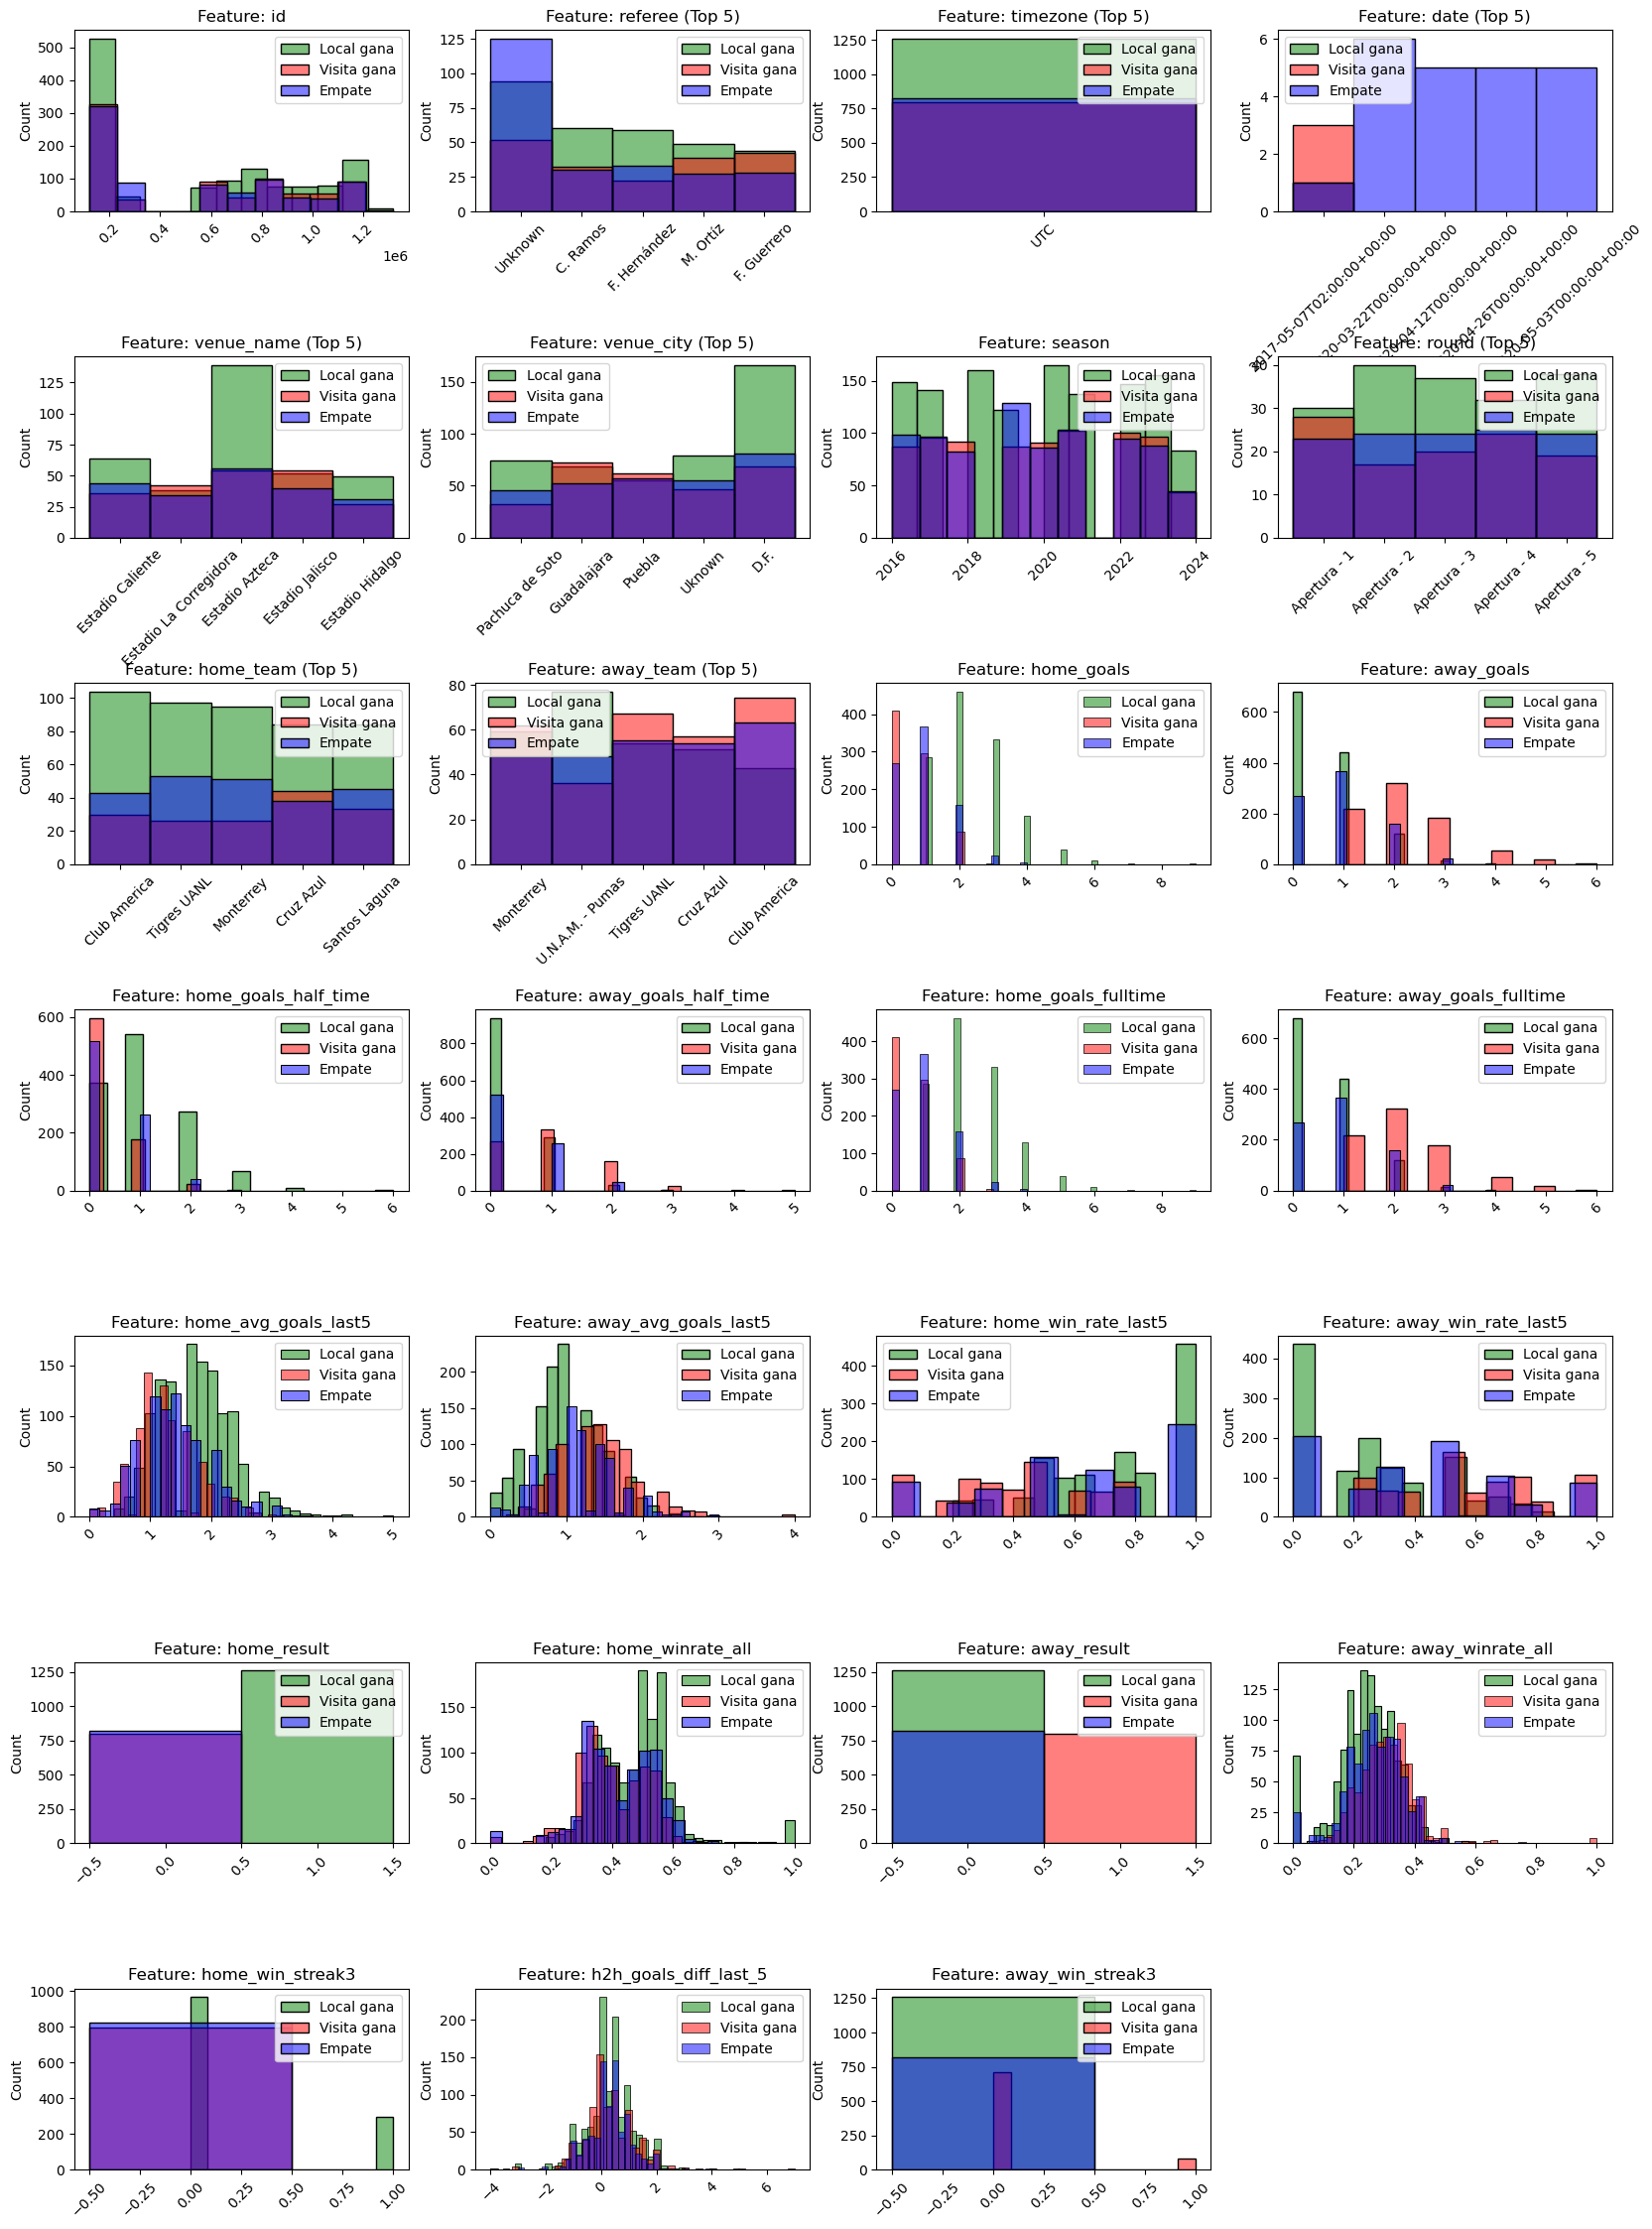

In [214]:
n_features = len(features.columns)
n_cols = 4
n_rows = (n_features // n_cols) + 1

plt.figure(figsize=(20, n_rows * 4))
gs = gridspec.GridSpec(n_rows, n_cols)
gs.update(hspace=0.8)

for i, f in enumerate(features.columns):
    ax = plt.subplot(gs[i])
    if df[f].dtype == "object":
        top5 = df[f].value_counts().nlargest(5).index
        df_filtered = df[df[f].isin(top5)]
    else:
        df_filtered = df  # numéricas completas
    
    sns.histplot(data=df_filtered[df_filtered["Class"] == 1], x=f, kde=False, 
                 color="green", stat="count", label="Local gana", alpha=0.5)
    sns.histplot(data=df_filtered[df_filtered["Class"] == -1], x=f, kde=False, 
                 color="red", stat="count", label="Visita gana", alpha=0.5)
    sns.histplot(data=df_filtered[df_filtered["Class"] == 0], x=f, kde=False, 
                 color="blue", stat="count", label="Empate", alpha=0.5)
    
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f} (Top 5)" if df[f].dtype == "object" else f"Feature: {f}")
    ax.legend()
    plt.xticks(rotation=45)

plt.show()


In [215]:
numeric_df = df.select_dtypes(include=["number"])
pca = PCA(n_components=2)

In [216]:
pca_result = pca.fit_transform(numeric_df.drop("Class", axis=1))

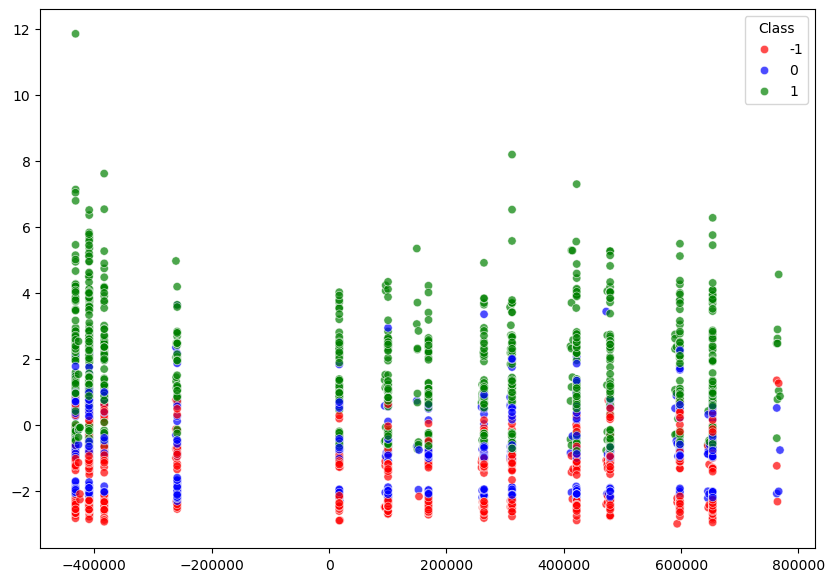

In [217]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], hue=df["Class"], palette={1:"green", -1:"red", 0:"blue"}, alpha=0.7)
plt.show()

La proyección de dos dimensiones muestra los partidos ganados por el equipo local (verde), visitante (rojo), y empates(azul), no presentan una separación clara utilizando unicamente las variables numericas. Esto indica que dichas caracteristicas no son suficientes para predecir el resultado, será necesario incluir variables categoricas como el equipo, estadio, y el árbrito.

### 3. División del conjunto de datos

In [218]:
train_set, val_set, test_set = train_val_test_split(X)

In [219]:
X_train , y_train = remove_labels(train_set, 'Class')
X_val, y_val = remove_labels(val_set, 'Class')
X_test, y_test = remove_labels(test_set, 'Class')

### 4. Preprocesamiento de los datos

In [220]:
#Definimos las columnas numericas
numeric_features = [
    "home_avg_goals_last5", 
    "away_avg_goals_last5", 
    "home_win_rate_last5", 
    "away_win_rate_last5",
    "home_win_streak3",
    "away_win_streak3",
    "home_winrate_all",
    "away_winrate_all",
    "h2h_goals_diff_last_5"
]

In [221]:
# Definimos las columnas categoricas
categorical_features = [
    "home_team", 
    "away_team", 
    "venue_name", 
    "venue_city", 
    "round", 
    "referee", 
    "timezone", 
    "season"
]

In [222]:
# Preprocesado con escalado
preprocessor_scaling = ColumnTransformer(
    transformers = [
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

In [223]:
# Preprocesador sin escalado ideal para Random Forest
preprocessor_no_scaling = ColumnTransformer(
  transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features)
    ]
)

### 5. Entrenamiento de los modelos

#### _Regresión Logistica_

Primero veamos el comportamiento cuando se entrena el modelo con regresión logistica para dos caracteristicas unicamente, para ello, se utilizara la selección de caracterisiticas mediante PCA

In [224]:
pca_pipeline = Pipeline([
    ("preprocessor", preprocessor_scaling),
    ("pca", PCA(n_components=2))
])

In [225]:
# Transformar los datos 
X_train_pca = pca_pipeline.fit_transform(X_train)
X_val_pca = pca_pipeline.fit_transform(X_val)
X_test_pca = pca_pipeline.fit_transform(X_test)

In [226]:
# Entrenar el modelo con Regresión Logistica
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_pca, y_train)

LogisticRegression(max_iter=1000)

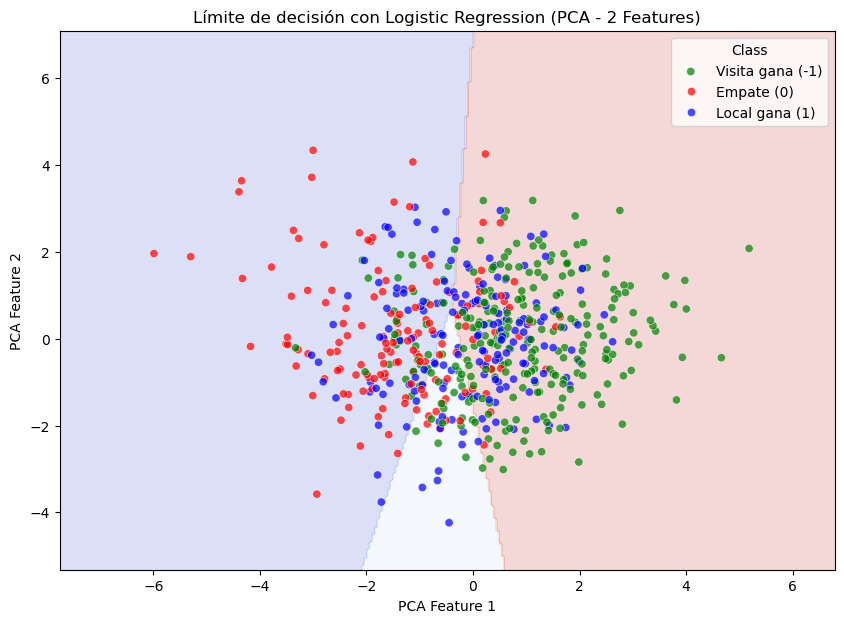

In [227]:
#Graficamos el limite de decision
plt.figure(figsize=(10,7))
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2, cmap=plt.cm.coolwarm)
sns.scatterplot(x=X_val_pca[:, 0], y=X_val_pca[:, 1], hue=y_val,
                palette={1: "green", -1: "red", 0: "blue"}, alpha=0.7)
plt.title("Límite de decisión con Logistic Regression (PCA - 2 Features)")
plt.xlabel("PCA Feature 1")
plt.ylabel("PCA Feature 2")
plt.legend(title="Class", labels=["Visita gana (-1)", "Empate (0)", "Local gana (1)"])
plt.show()

In [228]:
y_val_pred = log_reg.predict(X_val_pca)
# Calcular el F1 Score ponderado
print("F1 Score (Validación):", f1_score(y_val, y_val_pred, average="weighted"))

F1 Score (Validación): 0.5314097933943857


Ahora entrenamos el modelo con Regresión Logisitca con todo las caracteristicas de entrada

In [229]:
log_reg = Pipeline(steps=[
       ("preprocessor", preprocessor_scaling),
    ("classifier", LogisticRegression(max_iter=1000, C=0.1, penalty="l2", multi_class="multinomial", solver="lbfgs"))
])

In [230]:
log_reg.fit(X_train, y_train)

c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['home_avg_goals_last5',
                                                   'away_avg_goals_last5',
                                                   'home_win_rate_last5',
                                                   'away_win_rate_last5',
                                                   'home_win_streak3',
                                                   'away_win_streak3',
                                                   'home_winrate_all',
                                                   'away_winrate_all',
                                                   'h2h_goals_diff_last_5']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['home_team', 'away_team',
                                                   'venue_name', 'venue_city',
                                                   'round', 'referee',
                                                   'timezone', 'season'])])),
                ('classifier',
                 LogisticRegression(C=0.1, max_iter=1000,
                                    multi_class='multinomial'))])

In [231]:
#prediccion con los datos de entranmiento
y_train_pred = log_reg.predict(X_train)

In [232]:
print("F1 Score (Train):", f1_score(y_train, y_train_pred, average="weighted"))

F1 Score (Train): 0.6743927004214414


In [233]:
# Al parecer presenta overfiting 
y_val_pred   = log_reg.predict(X_val)

In [234]:
print("F1 Score (Val):", f1_score(y_val, y_val_pred, average="weighted"))

F1 Score (Val): 0.5709943933142918


In [235]:
y_test_pred  = log_reg.predict(X_test)

In [236]:
print("F1 Score (Test):", f1_score(y_test, y_test_pred, average="weighted"))

F1 Score (Test): 0.567736453522255


#### _Random Forest_

In [237]:
# Definir modelo
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

In [238]:
# Pipeline completo (preprocesamiento + modelo)
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_no_scaling),
    ("classifier", rf_clf)
])

In [239]:
# Entrenar
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['home_avg_goals_last5',
                                                   'away_avg_goals_last5',
                                                   'home_win_rate_last5',
                                                   'away_win_rate_last5',
                                                   'home_win_streak3',
                                                   'away_win_streak3',
                                                   'home_winrate_all',
                                                   'away_winrate_all',
                                                   'h2h_goals_diff_last_5']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['home_team', 'away_team',
                                                   'venue_name', 'venue_city',
                                                   'round', 'referee',
                                                   'timezone', 'season'])])),
                ('classifier',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])

In [240]:
y_train_pred = rf_pipeline.predict(X_train)

In [241]:
print("F1 Score (Train):", f1_score(y_train, y_train_pred, average="weighted"))

F1 Score (Train): 1.0


In [242]:
y_val_pred = rf_pipeline.predict(X_val)

In [243]:
print("F1 Score (Val):", f1_score(y_val, y_val_pred, average="weighted"))

F1 Score (Val): 0.5877617123758088


In [244]:
y_test_pred = rf_pipeline.predict(X_test)

In [245]:
print("F1 Score (Test):", f1_score(y_test, y_test_pred, average="weighted"))

F1 Score (Test): 0.547675560001431


#### _GridSearch_

In [246]:
from sklearn.model_selection import GridSearchCV

In [247]:
param_grid = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [None, 10, 20, 30],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2"]
}

In [248]:
# entrenar el modelo con GridSearchCV

grid_search = GridSearchCV(rf_pipeline, param_grid, 
                           scoring="f1_weighted", 
                           cv=3, n_jobs=1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   0.1s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=200; total time=   0.3s
[CV] END classifier__max_de

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['home_avg_goals_last5',
                                                                          'away_avg_goals_last5',
                                                                          'home_win_rate_last5',
                                                                          'away_win_rate_last5',
                                                                          'home_win_streak3',
                                                                          'away_win_streak3',
                                                                          'home_winrate_all',
                                                                          'away_winrate_all',
                                                                          'h2h_goals_diff_last_5']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'...
                                                                          'season'])])),
                                       ('classifier',
                                        RandomForestClassifier(n_estimators=200,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=1,
             param_grid={'classifier__max_depth': [None, 10, 20, 30],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='f1_weighted', verbose=2)

In [249]:
print("Best params:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Best params: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best F1 Score: 0.6168256333296473


#### _XGBoost_

In [ ]:
pip install xgboost

In [250]:
from xgboost import XGBRFClassifier

In [251]:
xgb_clf = XGBRFClassifier(
     objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)

In [252]:
#Remapear la etiqyeta de salida, -1 -> 0, 0 -> 1, 1 -> 2
y_train_xgb = y_train.replace({-1: 0, 0: 1, 1: 2})
y_val_xgb   = y_val.replace({-1: 0, 0: 1, 1: 2})
y_test_xgb  = y_test.replace({-1: 0, 0: 1, 1: 2})

In [253]:
#Entrenamiento del modelo
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor_no_scaling ), 
    ("classifier", xgb_clf)
])
xgb_pipeline.fit(X_train, y_train_xgb)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['home_avg_goals_last5',
                                                   'away_avg_goals_last5',
                                                   'home_win_rate_last5',
                                                   'away_win_rate_last5',
                                                   'home_win_streak3',
                                                   'away_win_streak3',
                                                   'home_winrate_all',
                                                   'away_winrate_all',
                                                   'h2h_goals_diff_last_5']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['home...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None, max_bin=None,
                                 max_cat_threshold=None, max_cat_to_onehot=None,
                                 max_delta_step=None, max_depth=None,
                                 max_leaves=None, min_child_weight=None,
                                 missing=nan, monotone_constraints=None,
                                 multi_strategy=None, n_estimators=None,
                                 n_jobs=None, num_class=3,
                                 num_parallel_tree=None,
                                 objective='multi:softmax', ...))])

In [254]:
y_val_pred = xgb_pipeline.predict(X_val)
print("F1 Val:", f1_score(y_val_xgb, y_val_pred, average="weighted"))


F1 Val: 0.6159948338084272


In [255]:
y_test_pred = xgb_pipeline.predict(X_test)
print("F1 Test:", f1_score(y_test_xgb, y_test_pred, average="weighted"))


F1 Test: 0.6047130098566841


### Ensamble de los tres modelos entrenados

In [ ]:
from sklearn.ensemble import StackingClassifier


In [256]:
stacking_clf = StackingClassifier(
    estimators=[
        ("log_reg", log_reg),
        ("rf", rf_pipeline),
        ("xgb", xgb_pipeline)
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

In [257]:
#Entrenamos al modelo 
stacking_clf.fit(X_train, y_train_xgb)


c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\rafae\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

StackingClassifier(estimators=[('log_reg',
                                Pipeline(steps=[('preprocessor',
                                                 ColumnTransformer(transformers=[('num',
                                                                                  StandardScaler(),
                                                                                  ['home_avg_goals_last5',
                                                                                   'away_avg_goals_last5',
                                                                                   'home_win_rate_last5',
                                                                                   'away_win_rate_last5',
                                                                                   'home_win_streak3',
                                                                                   'away_win_streak3',
                                                                                   'home_winrate_all',
                                                                                   'away_winrate_all',
                                                                                   'h2h_goals_diff_last_5']),
                                                                                 ('cat',
                                                                                  OneHotEncoder(handle...
                                                                 interaction_constraints=None,
                                                                 max_bin=None,
                                                                 max_cat_threshold=None,
                                                                 max_cat_to_onehot=None,
                                                                 max_delta_step=None,
                                                                 max_depth=None,
                                                                 max_leaves=None,
                                                                 min_child_weight=None,
                                                                 missing=nan,
                                                                 monotone_constraints=None,
                                                                 multi_strategy=None,
                                                                 n_estimators=None,
                                                                 n_jobs=None,
                                                                 num_class=3,
                                                                 num_parallel_tree=None,
                                                                 objective='multi:softmax', ...))]))],
                   final_estimator=LogisticRegression(max_iter=1000))

In [258]:
print("F1 Val:", f1_score(y_val_xgb, stacking_clf.predict(X_val), average="weighted"))
print("F1 Test:", f1_score(y_test_xgb, stacking_clf.predict(X_test), average="weighted"))

F1 Val: 0.6221954228114842
F1 Test: 0.6218749226481362


### _Red neuronal Multicapa_

Ahora se hara la comparación para obtener el mejor modelo posible, comparando un entrenamiento con una red neuronal multicapa y con el Stacking que se obtuvo luego de combinar tres modelos de clasificación. Esto es sumamente interesante, una vez seleccionado, haremos un pronostico con nuevos datos para observar las probabilidades de los juegos en el torneo actual

In [ ]:
pip install tensorflow

In [259]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from scipy import sparse


In [260]:

X_train_nn = preprocessor_no_scaling.fit_transform(X_train)
X_val_nn   = preprocessor_no_scaling.transform(X_val)
X_test_nn  = preprocessor_no_scaling.transform(X_test)


def to_float32(X):
    if sparse.issparse(X):
        return np.array(X.todense(), dtype=np.float32)
    else:
        return np.array(X, dtype=np.float32)

X_train_nn = to_float32(X_train_nn)
X_val_nn   = to_float32(X_val_nn)
X_test_nn  = to_float32(X_test_nn)


In [261]:

n_features = X_train_nn.shape[1]

model = Sequential([
    Dense(256, activation="relu", input_shape=(X_train_nn.shape[1],)),
    Dropout(0.3),                       # Evita overfitting
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dense(3, activation="softmax")      # 3 clases: local, empate, visitante
])
# Optimizador con LR ajustable
optimizer = Adam(learning_rate=1e-3)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# Early stopping para evitar sobreentrenar
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


c:\Users\rafae\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [262]:
# Entrnar la red neuronal
history = model.fit(
    X_train_nn, y_train_xgb,
    epochs=50,                  # más epochs
    batch_size=32,
    validation_data=(X_val_nn, y_val_xgb),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4748 - loss: 1.0186 - val_accuracy: 0.5583 - val_loss: 0.9298
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5832 - loss: 0.8747 - val_accuracy: 0.5722 - val_loss: 0.8960
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6301 - loss: 0.7859 - val_accuracy: 0.5513 - val_loss: 0.8887
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6754 - loss: 0.7203 - val_accuracy: 0.5374 - val_loss: 0.8968
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7206 - loss: 0.6519 - val_accuracy: 0.5478 - val_loss: 0.9509
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7554 - loss: 0.5821 - val_accuracy: 0.5530 - val_loss: 0.9760
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8041 - loss: 0.4825 - val_accuracy: 0.5409 - val_loss: 1.0208
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8377 - loss: 0.4178 - val_accuracy: 0.5357 - val_loss:

In [263]:
y_val_pred_nn  = model.predict(X_val_nn)
y_val_pred_nn  = np.argmax(y_val_pred_nn, axis=1)
print("F1 Val:", f1_score(y_val_xgb, y_val_pred_nn, average="weighted"))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
F1 Val: 0.5348268409545145


In [264]:
y_test_pred_nn = model.predict(X_test_nn)
y_test_pred_nn = np.argmax(y_test_pred_nn, axis=1)
print("F1 Test:", f1_score(y_test_xgb, y_test_pred_nn, average="weighted"))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
F1 Test: 0.5398370591787311


## Conclusión de Resultados

Durante la experimentación se probaron diferentes modelos de Machine Learning para la predicción de resultados de partidos de fútbol (local, empate, visitante):

- **Logistic Regression**  
  - F1 Test ≈ **0.56**
  - Modelo sencillo, pero con rendimiento limitado.

- **Random Forest**  
  - F1 Test ≈ **0.54**
  - Tendencia al sobreajuste en entrenamiento, sin gran mejora en validación.

- **XGBoost (XGBRFClassifier)**  
  - F1 Test ≈ **0.60**
  - Mejor rendimiento individual entre los modelos probados.

- **Red Neuronal Multicapa (MLP)**  
  - F1 Test ≈ **0.50**
  - No logró superar a los ensambles clásicos en este dataset tabular.

- **Stacking (Logistic Regression + Random Forest + XGBoost)**  
  - F1 Test ≈ **0.62**
  - El mejor desempeño general, superando a los modelos individuales.



## Modelo Seleccionado
Se utilizará **StackingClassifier** como modelo final, ya que obtuvo el **mejor F1 Score en validación y test (≈0.62)**.  
Este modelo servirá como base para generar predicciones probabilísticas (`predict_proba`) en nuevos partidos, permitiendo expresar resultados en términos de probabilidades (ejemplo: *América 70%, Empate 10%, Chivas 20%*).

## Nueva predicción

In [265]:
df_pred_game_nine = pd.read_csv(
    "datasets/jornada9_ap_25.csv",
    index_col=False   # evita que use la primera columna como índice
)
df_historic = pd.read_csv("datasets/2016-2024_liga_mx.csv")

In [266]:
df_pred_game_nine

,id,referee,timezone,date,venue_id,venue_name,venue_city,season,round,home_team,...,home_goals,away_goals,home_goals_half_time,away_goals_half_time,home_goals_fulltime,away_goals_fulltime,home_goals_extra_time,away_goals_extratime,home_goals_penalty,away_goals_penalty
0,2025072,NaN,UTC,2025-09-19T19:00:00+00:00,NaN,Estadio Azteca,D.F.,2025,Apertura - 9,Cruz Azul,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025073,NaN,UTC,2025-09-19T19:00:00+00:00,NaN,Estadio Victoria,Aguascalientes,2025,Apertura - 9,Necaxa,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025074,NaN,UTC,2025-09-19T21:00:00+00:00,NaN,Estadio de Mazatlán,Mazatlán,2025,Apertura - 9,Mazatlán,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025075,NaN,UTC,2025-09-19T21:05:00+00:00,NaN,Estadio Caliente,Tijuana,2025,Apertura - 9,Club Tijuana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025076,NaN,UTC,2025-09-20T17:00:00+00:00,NaN,Estadio Hidalgo,Pachuca de Soto,2025,Apertura - 9,Pachuca,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2025077,NaN,UTC,2025-09-20T19:07:00+00:00,NaN,Estadio AKRON,Zapopan,2025,Apertura - 9,Guadalajara Chivas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2025078,NaN,UTC,2025-09-20T21:05:00+00:00,NaN,Estadio BBVA,Guadalupe,2025,Apertura - 9,Monterrey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2025079,NaN,UTC,2025-09-21T17:00:00+00:00,NaN,Estadio Nuevo Corona,Torreón,2025,Apertura - 9,Santos Laguna,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2025080,NaN,UTC,2025-09-20T19:00:00+00:00,NaN,Estadio Olímpico de Universitario,D.F.,2025,Apertura - 9,U.N.A.M. - Pumas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [267]:
df_total_1 = pd.concat([df_historic, df_pred_game_nine], ignore_index=True)
df_total_1

,id,referee,timezone,date,venue_id,venue_name,venue_city,season,round,home_team,...,home_goals,away_goals,home_goals_half_time,away_goals_half_time,home_goals_fulltime,away_goals_fulltime,home_goals_extra_time,away_goals_extratime,home_goals_penalty,away_goals_penalty
0,864095,D. Quintero,UTC,2022-07-02T02:05:00+00:00,10546.0,Estadio de Mazatlán,Mazatlán,2022,Apertura - 1,Mazatlán,...,2.0,4.0,0.0,2.0,2.0,4.0,NaN,NaN,NaN,NaN
1,864096,I. Lopez,UTC,2022-07-02T22:00:00+00:00,1076.0,Estadio AKRON,Zapopan,2022,Apertura - 1,Guadalajara Chivas,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,864094,L. Santander,UTC,2022-07-02T22:00:00+00:00,1080.0,Estadio Victoria de Aguascalientes,Aguascalientes,2022,Apertura - 1,Necaxa,...,1.0,3.0,1.0,2.0,1.0,3.0,NaN,NaN,NaN,NaN
3,864097,Ó. Mejía,UTC,2022-07-03T00:05:00+00:00,1087.0,Estadio Universitario de Nuevo León,San Nicolás de los Garza,2022,Apertura - 1,Tigres UANL,...,2.0,3.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,NaN
4,864098,F. Guerrero,UTC,2022-07-03T02:05:00+00:00,7182.0,Estadio Azteca,D.F.,2022,Apertura - 1,Club America,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,2025076,NaN,UTC,2025-09-20T17:00:00+00:00,NaN,Estadio Hidalgo,Pachuca de Soto,2025,Apertura - 9,Pachuca,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2881,2025077,NaN,UTC,2025-09-20T19:07:00+00:00,NaN,Estadio AKRON,Zapopan,2025,Apertura - 9,Guadalajara Chivas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2882,2025078,NaN,UTC,2025-09-20T21:05:00+00:00,NaN,Estadio BBVA,Guadalupe,2025,Apertura - 9,Monterrey,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2883,2025079,NaN,UTC,2025-09-21T17:00:00+00:00,NaN,Estadio Nuevo Corona,Torreón,2025,Apertura - 9,Santos Laguna,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [268]:
#Agregar nuevas caracteristicas de entrada para mejores pronosticos
df_total_1 = add_team_features(df_total_1)
df_total_1 = add_home_away_strength(df_total_1)
df_total_1 = add_home_win_streak(df_total_1)
df_total_1 = add_h2h_feature(df_total_1)
df_total_1 = add_away_win_streak(df_total_1)

# Agregar la etiqueta de salida
df_total_1 = add_result_label(df_total_1)
df_total_1

#Detectar partidos futuros (sin goles reales)
mask_future = (
    df_total_1["season"].eq(2025) & 
    df_total_1["round"].eq("Apertura - 9")
)

# Volver a NaN la etiqueta en esos partidos
df_total_1.loc[mask_future, "Class"] = None

df_total_1

,id,referee,timezone,date,venue_id,venue_name,venue_city,season,round,home_team,...,home_win_rate_last5,away_win_rate_last5,home_result,home_winrate_all,away_result,away_winrate_all,home_win_streak3,h2h_goals_diff_last_5,away_win_streak3,Class
2542,143760,NaN,UTC,2016-07-16T02:00:00+00:00,1088.0,Estadio Caliente,Tijuana,2016,Apertura - 1,Club Tijuana,...,1.000000,0.000000,1,1.000000,0,0.000000,0,-0.6,0,1.0
2543,143761,NaN,UTC,2016-07-16T22:00:00+00:00,1084.0,Estadio La Corregidora,Santiago de Queretaro,2016,Apertura - 1,Club Queretaro,...,1.000000,0.000000,1,1.000000,0,0.000000,0,-1.0,0,1.0
2544,143762,NaN,UTC,2016-07-17T00:00:00+00:00,NaN,Estadio BBVA Bancomer,Monterrey,2016,Apertura - 1,Monterrey,...,NaN,NaN,0,0.000000,0,0.000000,0,0.2,0,0.0
2545,143763,NaN,UTC,2016-07-17T00:00:00+00:00,1071.0,Estadio Jalisco,Guadalajara,2016,Apertura - 1,Atlas,...,NaN,NaN,0,0.000000,0,0.000000,0,1.4,0,0.0
2546,143764,NaN,UTC,2016-07-17T00:06:00+00:00,NaN,Estadio Miguel Hidalgo,Pachuca de Soto,2016,Apertura - 1,Pachuca,...,1.000000,0.000000,1,1.000000,0,0.000000,0,1.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,2025076,NaN,UTC,2025-09-20T17:00:00+00:00,NaN,Estadio Hidalgo,Pachuca de Soto,2025,Apertura - 9,Pachuca,...,0.250000,0.333333,0,0.484472,0,0.192053,0,0.0,0,NaN
2884,2025080,NaN,UTC,2025-09-20T19:00:00+00:00,NaN,Estadio Olímpico de Universitario,D.F.,2025,Apertura - 9,U.N.A.M. - Pumas,...,0.500000,0.333333,0,0.433962,0,0.378531,0,-0.4,0,NaN
2881,2025077,NaN,UTC,2025-09-20T19:07:00+00:00,NaN,Estadio AKRON,Zapopan,2025,Apertura - 9,Guadalajara Chivas,...,0.333333,0.500000,0,0.398773,0,0.259259,0,0.4,0,NaN
2882,2025078,NaN,UTC,2025-09-20T21:05:00+00:00,NaN,Estadio BBVA,Guadalupe,2025,Apertura - 9,Monterrey,...,1.000000,1.000000,0,0.549133,0,0.408840,0,-0.2,0,NaN


In [269]:
df_total_1.isna().any()

id                       False
referee                   True
timezone                 False
date                     False
venue_id                  True
venue_name               False
venue_city                True
season                   False
round                    False
home_team                False
away_team                False
home_win                  True
away_win                  True
home_goals                True
away_goals                True
home_goals_half_time      True
away_goals_half_time      True
home_goals_fulltime       True
away_goals_fulltime       True
home_goals_extra_time     True
away_goals_extratime      True
home_goals_penalty        True
away_goals_penalty        True
home_avg_goals_last5     False
away_avg_goals_last5     False
home_win_rate_last5       True
away_win_rate_last5       True
home_result              False
home_winrate_all         False
away_result              False
away_winrate_all         False
home_win_streak3         False
h2h_goal

In [270]:
df_total_1 = df_total_1.drop(columns=[  'home_goals_extra_time',
    'away_goals_extratime',
    'home_goals_penalty',
    'away_goals_penalty',
    'home_win',
    'away_win',
    'venue_id'])
#Rellenar con unkwown
df_total_1['referee'] = df_total_1['referee'].fillna('Unknown')
df_total_1['venue_city'] = df_total_1['venue_city'].fillna('Uknown')
df_total_1

,id,referee,timezone,date,venue_name,venue_city,season,round,home_team,away_team,...,home_win_rate_last5,away_win_rate_last5,home_result,home_winrate_all,away_result,away_winrate_all,home_win_streak3,h2h_goals_diff_last_5,away_win_streak3,Class
2542,143760,Unknown,UTC,2016-07-16T02:00:00+00:00,Estadio Caliente,Tijuana,2016,Apertura - 1,Club Tijuana,Monarcas,...,1.000000,0.000000,1,1.000000,0,0.000000,0,-0.6,0,1.0
2543,143761,Unknown,UTC,2016-07-16T22:00:00+00:00,Estadio La Corregidora,Santiago de Queretaro,2016,Apertura - 1,Club Queretaro,Veracruz,...,1.000000,0.000000,1,1.000000,0,0.000000,0,-1.0,0,1.0
2544,143762,Unknown,UTC,2016-07-17T00:00:00+00:00,Estadio BBVA Bancomer,Monterrey,2016,Apertura - 1,Monterrey,Puebla,...,NaN,NaN,0,0.000000,0,0.000000,0,0.2,0,0.0
2545,143763,Unknown,UTC,2016-07-17T00:00:00+00:00,Estadio Jalisco,Guadalajara,2016,Apertura - 1,Atlas,Toluca,...,NaN,NaN,0,0.000000,0,0.000000,0,1.4,0,0.0
2546,143764,Unknown,UTC,2016-07-17T00:06:00+00:00,Estadio Miguel Hidalgo,Pachuca de Soto,2016,Apertura - 1,Pachuca,Leon,...,1.000000,0.000000,1,1.000000,0,0.000000,0,1.0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2880,2025076,Unknown,UTC,2025-09-20T17:00:00+00:00,Estadio Hidalgo,Pachuca de Soto,2025,Apertura - 9,Pachuca,Club Queretaro,...,0.250000,0.333333,0,0.484472,0,0.192053,0,0.0,0,NaN
2884,2025080,Unknown,UTC,2025-09-20T19:00:00+00:00,Estadio Olímpico de Universitario,D.F.,2025,Apertura - 9,U.N.A.M. - Pumas,Tigres UANL,...,0.500000,0.333333,0,0.433962,0,0.378531,0,-0.4,0,NaN
2881,2025077,Unknown,UTC,2025-09-20T19:07:00+00:00,Estadio AKRON,Zapopan,2025,Apertura - 9,Guadalajara Chivas,Toluca,...,0.333333,0.500000,0,0.398773,0,0.259259,0,0.4,0,NaN
2882,2025078,Unknown,UTC,2025-09-20T21:05:00+00:00,Estadio BBVA,Guadalupe,2025,Apertura - 9,Monterrey,Club America,...,1.000000,1.000000,0,0.549133,0,0.408840,0,-0.2,0,NaN


In [271]:
df_hist_ready = df_total_1[df_total_1["Class"].notna()].copy()
df_future_ready = df_total_1[df_total_1["Class"].isna()].copy()

print("Histórico:", df_hist_ready.shape)
print("Futuro:", df_future_ready.shape)

Histórico: (2876, 28)
Futuro: (9, 28)


In [272]:
df_future_ready

,id,referee,timezone,date,venue_name,venue_city,season,round,home_team,away_team,...,home_win_rate_last5,away_win_rate_last5,home_result,home_winrate_all,away_result,away_winrate_all,home_win_streak3,h2h_goals_diff_last_5,away_win_streak3,Class
2876,2025072,Unknown,UTC,2025-09-19T19:00:00+00:00,Estadio Azteca,D.F.,2025,Apertura - 9,Cruz Azul,FC Juarez,...,0.666667,0.750000,0,0.502994,0,0.197917,0,1.4,0,NaN
2877,2025073,Unknown,UTC,2025-09-19T19:00:00+00:00,Estadio Victoria,Aguascalientes,2025,Apertura - 9,Necaxa,Puebla,...,0.000000,0.000000,0,0.333333,0,0.270968,0,0.2,0,NaN
2878,2025074,Unknown,UTC,2025-09-19T21:00:00+00:00,Estadio de Mazatlán,Mazatlán,2025,Apertura - 9,Mazatlán,Atlas,...,0.333333,0.333333,0,0.350649,0,0.231250,0,0.4,0,NaN
2879,2025075,Unknown,UTC,2025-09-19T21:05:00+00:00,Estadio Caliente,Tijuana,2025,Apertura - 9,Club Tijuana,Leon,...,0.750000,0.500000,0,0.455128,0,0.354037,0,0.4,0,NaN
2880,2025076,Unknown,UTC,2025-09-20T17:00:00+00:00,Estadio Hidalgo,Pachuca de Soto,2025,Apertura - 9,Pachuca,Club Queretaro,...,0.250000,0.333333,0,0.484472,0,0.192053,0,0.0,0,NaN
2884,2025080,Unknown,UTC,2025-09-20T19:00:00+00:00,Estadio Olímpico de Universitario,D.F.,2025,Apertura - 9,U.N.A.M. - Pumas,Tigres UANL,...,0.500000,0.333333,0,0.433962,0,0.378531,0,-0.4,0,NaN
2881,2025077,Unknown,UTC,2025-09-20T19:07:00+00:00,Estadio AKRON,Zapopan,2025,Apertura - 9,Guadalajara Chivas,Toluca,...,0.333333,0.500000,0,0.398773,0,0.259259,0,0.4,0,NaN
2882,2025078,Unknown,UTC,2025-09-20T21:05:00+00:00,Estadio BBVA,Guadalupe,2025,Apertura - 9,Monterrey,Club America,...,1.000000,1.000000,0,0.549133,0,0.408840,0,-0.2,0,NaN
2883,2025079,Unknown,UTC,2025-09-21T17:00:00+00:00,Estadio Nuevo Corona,Torreón,2025,Apertura - 9,Santos Laguna,Atletico San Luis,...,0.000000,0.500000,0,0.515337,0,0.240385,0,0.0,0,NaN


In [275]:
df_future_ready.isna().any()


id                       False
referee                  False
timezone                 False
date                     False
venue_name               False
venue_city               False
season                   False
round                    False
home_team                False
away_team                False
home_goals                True
away_goals                True
home_goals_half_time      True
away_goals_half_time      True
home_goals_fulltime       True
away_goals_fulltime       True
home_avg_goals_last5     False
away_avg_goals_last5     False
home_win_rate_last5      False
away_win_rate_last5      False
home_result              False
home_winrate_all         False
away_result              False
away_winrate_all         False
home_win_streak3         False
h2h_goals_diff_last_5    False
away_win_streak3         False
Class                     True
dtype: bool

In [276]:
#Definimos las columnas numericas
numeric_features = [ 
    "home_avg_goals_last5", 
    "away_avg_goals_last5", 
    "home_win_rate_last5", 
    "away_win_rate_last5", 
    "home_win_streak3", 
    "away_win_streak3", 
    "home_winrate_all", 
    "away_winrate_all", 
    "h2h_goals_diff_last_5" 
]

In [278]:
# Definimos las columnascategoricas 
categorical_features = [ "home_team", "away_team", "venue_name", "venue_city", "round", "referee", "timezone", "season" ]

In [279]:
X_future = df_future_ready[preprocessor_no_scaling.feature_names_in_]

In [281]:
y_future_prep = stacking_clf.predict_proba(X_future)

In [287]:
# Armamos DataFrame con partidos + probabilidades
df_predictions = df_future_ready[["date", "home_team", "away_team"]].copy()
df_predictions["P_HomeWin"] = y_future_prep[:, 0] * 100
df_predictions["P_Draw"]    = y_future_prep[:, 1] * 100
df_predictions["P_AwayWin"] = y_future_prep[:, 2] * 100

In [288]:
df_predictions[["P_HomeWin","P_Draw","P_AwayWin"]] = df_predictions[["P_HomeWin","P_Draw","P_AwayWin"]].round(2)
# Ordenar por fecha
df_predictions = df_predictions.sort_values(by="date").reset_index(drop=True)


In [289]:
import pandas as pd
import IPython.display as disp


# Estilos para fondo oscuro
disp.display(
    df_predictions.style.format({
        "P_HomeWin": "{:.1f}%",
        "P_Draw": "{:.1f}%",
        "P_AwayWin": "{:.1f}%"
    }).set_properties(**{
        "text-align": "center",
        "color": "white",
        "background-color": "#121212"
    }).set_table_styles([
        {"selector": "th", "props": [("text-align", "center"), ("background-color", "#1f1f1f"), ("color", "#00ffcc"), ("font-weight","bold")]},
        {"selector": "tr:nth-child(even)", "props": [("background-color", "#1e1e1e")]},
        {"selector": "tr:nth-child(odd)", "props": [("background-color", "#2a2a2a")]}
    ])
)


,date,home_team,away_team,P_HomeWin,P_Draw,P_AwayWin
0,2025-09-19T19:00:00+00:00,Cruz Azul,FC Juarez,35.4%,40.2%,24.4%
1,2025-09-19T19:00:00+00:00,Necaxa,Puebla,3.1%,90.3%,6.6%
2,2025-09-19T21:00:00+00:00,Mazatlán,Atlas,23.1%,61.0%,15.8%
3,2025-09-19T21:05:00+00:00,Club Tijuana,Leon,32.6%,33.6%,33.9%
4,2025-09-20T17:00:00+00:00,Pachuca,Club Queretaro,33.1%,47.2%,19.7%
5,2025-09-20T19:00:00+00:00,U.N.A.M. - Pumas,Tigres UANL,20.9%,52.0%,27.1%
6,2025-09-20T19:07:00+00:00,Guadalajara Chivas,Toluca,38.7%,46.0%,15.3%
7,2025-09-20T21:05:00+00:00,Monterrey,Club America,5.1%,88.4%,6.5%
8,2025-09-21T17:00:00+00:00,Santos Laguna,Atletico San Luis,41.5%,47.0%,11.5%
